In [1]:
%%capture --no-display

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, get_complex_laplacian

# widget imports:
import nibabel as nib
from surfer import Brain as SB
from ipywidgets import interactive, widgets, fixed

## Examing and rendering brains for best eigenmode matches

In [2]:
%matplotlib inline

# House keeping
plt.style.use('seaborn')
data_dir = '../../data/'
hcp_dir = "../../data"


# Load Pablo's Yeo 2017 canonical network maps
com_dk = np.load(
    "../../data/com_dk.npy",
    allow_pickle = True
).item()
DK_df_normalized = pd.read_csv(
    "../../data/DK_dictionary_normalized.csv"
).set_index("Unnamed: 0")

# binarize:
ub, lb = 1, 0 #define binary boundaries

DKfc_binarized = pd.DataFrame(
    [], index=DK_df_normalized.index, columns=DK_df_normalized.columns
)
for name in DK_df_normalized.index:
    u = np.mean(np.nan_to_num(DK_df_normalized.loc[name].values))
    s = np.std(np.nan_to_num(DK_df_normalized.loc[name].values))
    threshold = u - s * 0.1
    DKfc_binarized.loc[name] = np.where(
        DK_df_normalized.loc[name].values > threshold, ub, lb
    )

#### Default network:

In [3]:
# load basin hopping results:
h5_path = path.get_file_path('Default_BH_dice.h5')
bh_default = path.read_hdf5(h5_path)
bh_default

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([4.17917141, 4.61932855, 2.92177579]),
  'fun': 0.6686860465116279,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([4.17917141, 4.61932855, 2.92177579]),
 'fun': 0.6686860465116279,
 'minimization_failures': 0,
 'nfev': 2505,
 'nit': 500,
 'njev': 501}

In [141]:
# Compute eigenmode dice with Brain:
dft_brain = Brain.Brain()
dft_brain.add_connectome(hcp_dir)
dft_brain.reorder_connectome(dft_brain.connectome, dft_brain.distance_matrix)
dft_brain.bi_symmetric_c()
dft_brain.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_default['x'][0]
dft_brain.add_laplacian_eigenmodes(w, alpha = bh_default['x'][1], speed = bh_default['x'][2])

# binarize and compute dice:
dft_brain.binary_eigenmodes = np.where(dft_brain.norm_eigenmodes > 0.6, 1, 0)
dft_dice = eigenmode.get_dice_df(dft_brain.binary_eigenmodes, DKfc_binarized)
# Compute mean Dice for chosen network:
dice_scores = 1-np.round(dft_dice['Default'].values.astype(np.double),3)
mean_dice = np.mean(dice_scores)
print("mean dice dissimilarity score: ", mean_dice)

mean dice dissimilarity score:  0.6686860465116279


In [142]:
np.min(dice_scores)

0.43300000000000005

In [143]:
ordered_dice = np.argsort(dice_scores)
ordered_dice

array([61, 37,  4, 78, 53, 59, 44, 29,  0, 56, 64, 50, 60, 62, 23, 17,  3,
       20, 16, 28, 38, 58, 32,  1, 63, 80, 81, 70, 43, 77, 73, 24, 67, 68,
       30, 15, 11, 82, 76, 55,  2, 27, 51, 39, 72,  7, 48, 46, 33,  9, 31,
       75, 41, 34, 25, 84, 14, 79,  6, 18, 21, 66, 45, 40, 85, 49, 47, 13,
       65, 22, 69, 57, 74, 42, 36, 54,  8, 10, 19,  5, 71, 12, 35, 26, 52,
       83])

In [147]:
dice_scores[78]

0.492

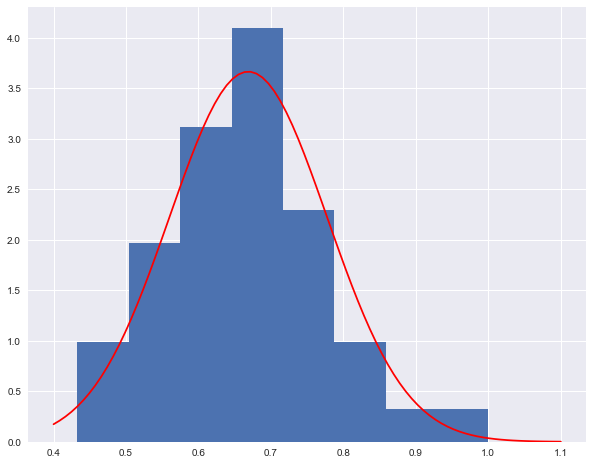

In [22]:
from nilearn import plotting
from matplotlib import cm

## Function for plotting with nilearn
def plot_glass_brain(coords, scores, cmap_name):
    """ Plot transparent brain renders
    Args:
        - color (list): Color indices
        - coords 
        - size
    Returns:
        -matplotlib object
    """
    cmap = cm.get_cmap(cmap_name)
    data = np.nan_to_num(scores)
    size = data*500
    #color = cmap((size/np.max(size)))
    color = cmap(data)
    connectome_array = np.array([[0]*86]*86)
    plotting.plot_connectome(connectome_array, coords, node_size = size, node_color = color, display_mode = 'xz')
    plt.gcf().set_size_inches(10, 5)

# plot:
plt.figure('Default System', figsize = [10,8])
plt.hist(dice_scores, bins = 8, density = True, histtype = 'bar')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(dice_scores))
mu, sigma = stats.norm.fit(dice_scores)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

In [21]:
np.argmax(dice_scores)

52

In [44]:
binarized_eig = np.where(dft_brain.norm_eigenmodes[:,52] > 0.6, 1, 0)
np.round(dft_brain.norm_eigenmodes[:,52],2)

array([0.26, 0.18, 0.17, 0.02, 0.19, 0.09, 0.12, 0.13, 0.09, 0.04, 0.15,
       0.02, 0.07, 0.15, 0.16, 0.07, 0.21, 0.18, 0.18, 0.  , 0.  , 0.16,
       0.02, 0.05, 0.14, 0.16, 0.06, 0.01, 0.15, 0.13, 0.12, 0.11, 0.22,
       0.14, 0.26, 0.17, 0.17, 0.02, 0.19, 0.09, 0.12, 0.13, 0.08, 0.04,
       0.16, 0.02, 0.06, 0.15, 0.15, 0.07, 0.21, 0.18, 0.18, 0.  , 0.  ,
       0.15, 0.02, 0.05, 0.13, 0.16, 0.05, 0.01, 0.15, 0.13, 0.12, 0.11,
       0.22, 0.15, 1.  , 0.18, 0.07, 0.06, 0.56, 0.13, 0.27, 0.05, 1.  ,
       1.  , 0.19, 0.07, 0.06, 0.56, 0.13, 0.27, 0.06, 1.  ])

In [45]:
np.round(DK_df_normalized.loc['Default'].values,2)

array([0.61, 0.07, 0.52, 0.  , 0.  , 0.  , 0.53, 0.15, 0.82, 0.  , 0.24,
       0.  , 0.34, 0.8 , 0.37, 0.  , 0.42, 0.85, 0.53, 0.  , 0.  , 0.32,
       0.01, 0.52, 0.92, 0.3 , 0.57, 0.  , 0.29, 0.14, 0.38, 0.  , 0.  ,
       0.02, 0.31, 0.12, 0.02, 0.  , 0.  , 0.  , 0.4 , 0.06, 0.64, 0.  ,
       0.17, 0.  , 0.39, 0.63, 0.09, 0.  , 0.13, 0.57, 0.19, 0.  , 0.  ,
       0.16, 0.  , 0.38, 0.96, 0.12, 0.53, 0.  , 0.21, 0.  , 0.2 , 0.  ,
       0.  , 0.01, 0.11,  nan,  nan, 0.  ,  nan, 0.26, 0.  , 0.  ,  nan,
       0.  ,  nan,  nan, 0.  ,  nan, 0.18, 0.  , 0.  ,  nan])

In [55]:
from scipy.spatial import distance
u = np.mean(np.nan_to_num(DK_df_normalized.loc['Default'].values))
s = np.std(np.nan_to_num(DK_df_normalized.loc['Default'].values))
threshold = u - s * 0.1
distance.dice(np.where(dft_brain.norm_eigenmodes[:,61]>0.6,1,0), np.where(np.nan_to_num(DK_df_normalized.loc['Default'].values)>threshold,1,0))

0.43333333333333335

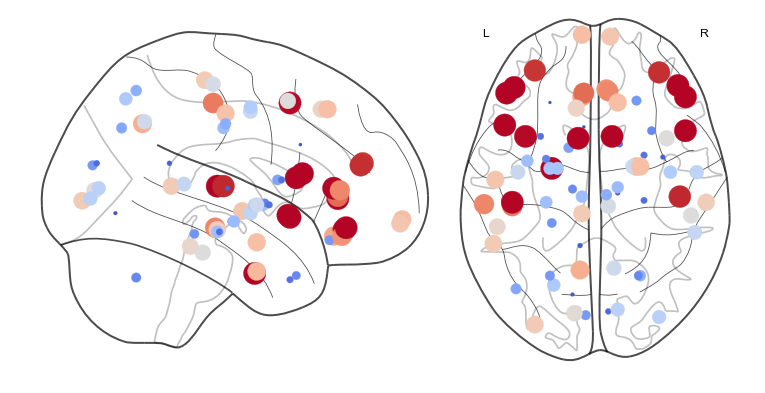

In [38]:
coords = np.array([com_dk[region] for region in DK_df_normalized.columns])
eigscore = dft_brain.norm_eigenmodes[:,61]
plot_glass_brain(coords, eigscore, 'coolwarm')

Trying linear regression:

In [102]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

k = 5 # number of top eigen modes to regress:
Y = dft_brain.norm_eigenmodes[:,ordered_dice[0:k]]
X = np.nan_to_num(DK_df_normalized.loc['Default'].values).reshape(-1,1)
regr = LinearRegression()
regr.fit(X,Y)
print(regr.score(X,Y))

0.10699878768186565


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [126]:
from sklearn.preprocessing import minmax_scale
lin_comb_y = np.dot(Y,np.asarray(regr.coef_))
scaled_y = np.squeeze(minmax_scale(lin_comb_y))

/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/nilearn/plotting/displays.py:1425: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


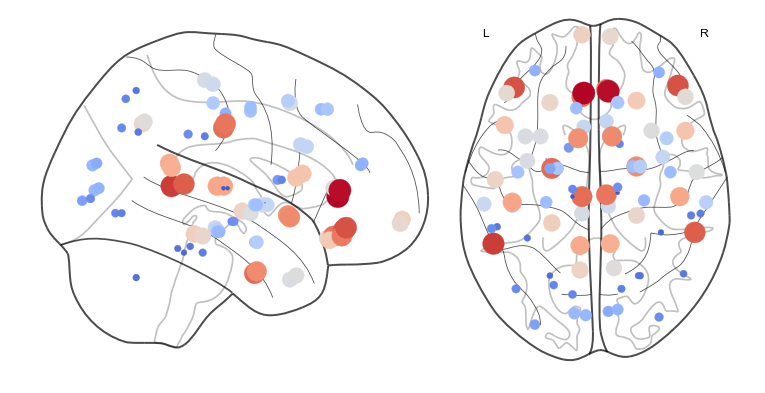

In [127]:
plot_glass_brain(coords, np.asarray(scaled_y), 'coolwarm')

In [114]:
a = np.array([[[1]*2]*5])
b = np.array([1,2])
print(a)
print(b.shape)
np.dot(a,b)

[[[1 1]
  [1 1]
  [1 1]
  [1 1]
  [1 1]]]
(2,)


array([[3, 3, 3, 3, 3]])

In [58]:
%gui qt

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "split"
surf = "inflated"

"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
dft_SB = SB(subject_id, hemi, surf, background = "white", title = "Default freq = 4.5, alpha = 5.3, v = 8.2", views=['lat', 'med'])
#limb_SB.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

# left side:
hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
lh_norm_eigs = dft_brain.norm_eigenmodes[:,np.argmin(dice_scores)]
lh_padded_eigs = np.insert(lh_norm_eigs, [0, 3], [0, 0])
dft_lh = lh_padded_eigs[labels]
dft_SB.add_data(dft_lh, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)

hemi_side = "rh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

rh_norm_eigs = dft_brain.norm_eigenmodes[34:68,np.argmin(dice_scores)]
rh_padded_eigs = np.insert(rh_norm_eigs, [0,3],[0,0])
dft_rh = rh_padded_eigs[labels]
dft_SB.add_data(dft_rh, hemi = 'rh', thresh = 0, colormap = "jet", remove_existing = True)

colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")


colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")


In [7]:
print(np.min(dice_scores))

0.433


#### Dorsal attention network

In [4]:
# load results:
h5_path = path.get_file_path('Dorsal_Attention_BH_dice.h5')
bh_dorattn = path.read_hdf5(h5_path)
bh_dorattn

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([ 2.62753374,  3.09871759, -0.03273678]),
  'fun': 0.8203953488372093,
  'message': 'Optimization terminated successfully.',
  'nfev': 30,
  'nit': 1,
  'njev': 6,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([ 2.62753374,  3.09871759, -0.03273678]),
 'fun': 0.8203953488372093,
 'minimization_failures': 0,
 'nfev': 2530,
 'nit': 500,
 'njev': 506}

#### Frontoparietal

In [5]:
h5_path = path.get_file_path('Frontoparietal_BH_dice.h5')
bh_ftpt = path.read_hdf5(h5_path)
bh_ftpt

{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([-0.47115614, -2.5191787 , 14.14344247]),
  'fun': 0.7265465116279068,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([-0.47115614, -2.5191787 , 14.14344247]),
 'fun': 0.7265465116279068,
 'minimization_failures': 0,
 'nfev': 2505,
 'nit': 500,
 'njev': 501}

#### Limbic

In [78]:
h5_path = path.get_file_path('Limbic_BH_dice.h5')
bh_limb = path.read_hdf5(h5_path)
bh_limb

/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


{'lowest_optimization_result': {'hess_inv': array([[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]]),
  'jac': array([0., 0., 0.]),
  'x': array([18.51450673,  0.7018993 ,  5.38656733]),
  'fun': 0.6152674418604651,
  'message': 'Optimization terminated successfully.',
  'nfev': 5,
  'nit': 0,
  'njev': 1,
  'status': 0,
  'success': True},
 'message': ['requested number of basinhopping iterations completed successfully'],
 'x': array([18.51450673,  0.7018993 ,  5.38656733]),
 'fun': 0.6152674418604651,
 'minimization_failures': 0,
 'nfev': 2505,
 'nit': 500,
 'njev': 501}

Plot eigenmode dice dissimilarity scores:

mean dice dissimilarity score:  0.6152674418604651


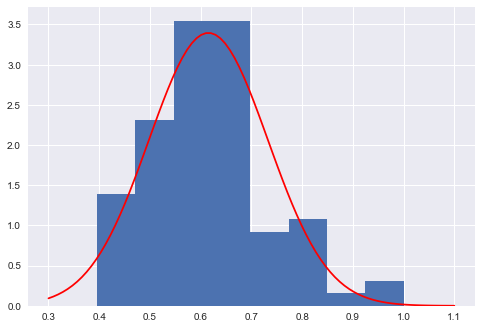

In [79]:
# Compute eigenmode dice with Brain:
limbic = Brain.Brain()
limbic.add_connectome(hcp_dir)
limbic.reorder_connectome(limbic.connectome, limbic.distance_matrix)
limbic.bi_symmetric_c()
limbic.reduce_extreme_dir()

# complex laplacian and its eigenmodes:
w = 2*np.pi*bh_limb['x'][0]
limbic.add_laplacian_eigenmodes(w, alpha = bh_limb['x'][1], speed = bh_limb['x'][2])

# binarize and compute dice:
limbic.binary_eigenmodes = np.where(limbic.norm_eigenmodes > 0.6, 1, 0)
limbic_dice = eigenmode.get_dice_df(limbic.binary_eigenmodes, DKfc_binarized)
# Compute mean Dice for chosen network:
dice_scores = 1-np.round(limbic_dice['Limbic'].values.astype(np.double),3)
mean_dice = np.mean(dice_scores)
print("mean dice dissimilarity score: ", mean_dice)

# plot:
plt.figure('Limbic System')
plt.hist(dice_scores, bins = 8, density = True, histtype = 'bar')
xvals = plt.xticks()[0]
xmin, xmax = min(xvals), max(xvals)
xbins = np.linspace(xmin, xmax, len(dice_scores))
mu, sigma = stats.norm.fit(dice_scores)
gaussian_pdf = stats.norm.pdf(xbins, mu, sigma)
plt.plot(xbins, gaussian_pdf,'r', label = 'Gaussian Fit')

In [81]:
np.argmin(dice_scores)

1

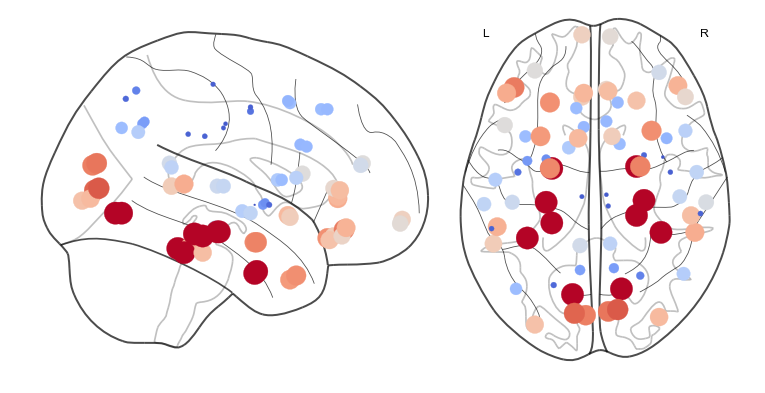

In [83]:
eigscore = limbic.norm_eigenmodes[:,np.argmin(dice_scores)]
plot_glass_brain(coords, eigscore, 'coolwarm')

Render brain for best dice score:

In [53]:
%gui qt

# set up Pysurfer variables
subject_id = "fsaverage"
hemi = "split"
surf = "inflated"

"""
Bring up the visualization.
"""
#brain = Brain(subject_id, hemi , surf, background="white", views = ['lat','med'])
limb_SB = SB(subject_id, hemi, surf, background = "white", title = "Limbic freq = 4.5, alpha = 5.3, v = 8.2", views=['lat', 'med'])
#limb_SB.add_text(x = 0.5, y = 0.9, text = "Eig Number , frequency = , speed = ", name = "eiglabel")

"""
Read in the automatic parcellation of sulci and gyri.
"""

# left side:
hemi_side = "lh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)
lh_norm_eigs = limbic.norm_eigenmodes[:,np.argmax(dice_scores)]
lh_padded_eigs = np.insert(lh_norm_eigs, [0, 3], [0, 0])
limb_lh = lh_padded_eigs[labels]
limb_SB.add_data(limb_lh, hemi = 'lh', thresh = 0, colormap = "jet", remove_existing = True)

hemi_side = "rh"
aparc_file = os.path.join(os.environ["SUBJECTS_DIR"],
                          subject_id, "label",
                          hemi_side + ".aparc.annot")
labels, ctab, names = nib.freesurfer.read_annot(aparc_file)

rh_norm_eigs = limbic.norm_eigenmodes[34:68,np.argmax(dice_scores)]
rh_padded_eigs = np.insert(rh_norm_eigs, [0,3],[0,0])
limb_rh = rh_padded_eigs[labels]
limb_SB.add_data(limb_rh, hemi = 'rh', thresh = 0, colormap = "jet", remove_existing = True)

/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")


colormap sequential: [0.00e+00, 5.00e-01, 1.00e+00] (opaque)
colormap sequential: [7.05e-02, 5.35e-01, 1.00e+00] (opaque)


/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
/home/axiezai/miniconda3/envs/spectral/lib/python3.6/site-packages/surfer/viz.py:3234: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
